In [1]:
# Imports
import cv2
import glob
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import tensorflow as tf
import time
import itertools
import seaborn as sns
import numpy as np
from numpy import expand_dims
import random
import keras
from keras import callbacks
from keras.layers.normalization import BatchNormalization
from keras import backend as k
from keras import regularizers
from keras.datasets import fashion_mnist
from keras.layers import Activation, Conv2D, Conv2DTranspose, Dense, Dropout, Flatten, Input, Lambda, MaxPooling2D, Reshape
from keras.layers.convolutional import UpSampling2D
from keras.losses import binary_crossentropy
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from timeit import default_timer as timer

<h3>
    Team Member: 
    
    Nitin Kulkarni - 50337029
    
    Xiao Zhang - 50312346 
    
    Sai Charith Reddy Pasula - 50320452
</h3>

<h3>Topic:</h3> 

We intended to build a state of the art CNN like <b>ResNet/InceptionNet</b> model to classify images and compare the results with a vanilla CNN like <b>AlexNet</b>.

<h3>Link to the images:</h3>

https://drive.google.com/file/d/1MrUq-v0AUFmgqANys-a6_XrHNIQow8mq/view?usp=sharing

# Don't run this block of code if you aren't using Tensorflow-GPU.

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("physical_devices-------------", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

physical_devices------------- 1


In [3]:
# Define the size of images because the input of AlexNet should have the same size.
ROWS = 227
COLS = 227
CHANNELS = 3
CLASSES = 30

In [4]:
def read_image(file_path): # Read images and convert it into the uniform size (224x224x3)
    img_start = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return cv2.resize(img_start, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

In [5]:
img_start = read_image('./images/ant/1.jpg')

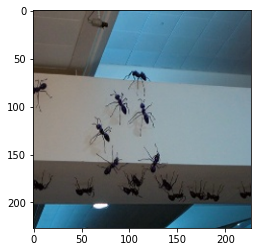

In [6]:
plt.imshow(img_start)

<h4>The size was exactly what we expected</h4>

In [7]:
print(np.shape(img_start))

(227, 227, 3)


<h4>Store the images and their folder name(it is also the label of the images) at the same time. In this way the images and the labels are in the same order. </h4>

In [8]:
filenames= os.listdir ('./images')
x_train = []
y_train = []
for folder in filenames: # Read the file name.
    for image in os.listdir(f'./images/{folder}'):# Use folder as parameter.
        img = read_image(f'./images/{folder}/{image}') # Read the files in each folder.
        x_train.append(img) # Append them (the file and label) in exact same order.
        y_train.append(folder)

<h4>Build a mapping between labels and pictures so that they can still have the same order after shuffling.</h4>

In [9]:
c = list(zip(x_train, y_train)) # build the relationship between image and label
random.shuffle(c) # shuffle
a, b = zip(*c) # get image and label back (the order of rows is changed but the label is always attached to image)

<h4>Check if the label match the picture.</h4>

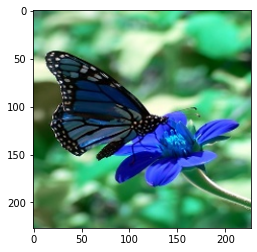

In [10]:
plt.imshow(a[1])

In [11]:
print(b[1]) # It is exactly what we expected.

monarch


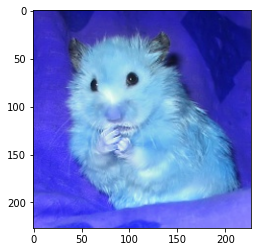

In [12]:
plt.imshow(a[111])

In [13]:
print(b[111]) # It is exactly what we expected.

rodent


<h4>Keras cannot deal with string label so we have to encode them.</h4>

In [14]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

In [15]:
label_encoder.fit(["African elephant", "ant", "asparagus", "bridge", "computer keyboard","cow","dining table","Ferris wheel","flower","French bulldog","gas pump","gorilla","hula-hoop","jelly bean","jellyfish","king penguin","kiwi","koala","limousine","monarch", "motorcycling", "rodent", "roller coaster", "sea slug", "seashore", "sewing machine", "skyscraper", "snail", "tiger", "wasp's nest"])

LabelEncoder()

In [16]:
b_label = np.copy(b)
b_label = label_encoder.transform(b_label)

In [17]:
print(b)# These are what the original labels look like.

('gorilla', 'monarch', 'gorilla', 'seashore', 'jelly bean', 'French bulldog', 'tiger', 'kiwi', 'gas pump', 'sea slug', 'hula-hoop', "wasp's nest", 'limousine', 'roller coaster', 'limousine', 'motorcycling', "wasp's nest", 'king penguin', 'limousine', 'cow', 'sea slug', 'computer keyboard', 'Ferris wheel', 'roller coaster', 'koala', 'gas pump', 'seashore', 'monarch', 'jellyfish', 'gas pump', 'flower', 'Ferris wheel', 'jellyfish', 'flower', 'rodent', 'kiwi', "wasp's nest", 'cow', 'Ferris wheel', 'jellyfish', 'kiwi', 'king penguin', 'roller coaster', 'jellyfish', 'sewing machine', 'roller coaster', 'flower', 'flower', 'sea slug', 'tiger', 'skyscraper', 'snail', 'rodent', 'ant', 'gas pump', 'asparagus', 'sewing machine', 'jellyfish', 'limousine', 'African elephant', 'hula-hoop', 'tiger', 'jelly bean', 'sea slug', 'gorilla', 'jellyfish', 'limousine', 'kiwi', 'gorilla', 'limousine', 'sea slug', 'hula-hoop', 'dining table', "wasp's nest", 'computer keyboard', 'motorcycling', 'skyscraper', 'je

In [18]:
print(b_label) # And we print the labels after encoding.

[11 19 11 ...  9 15 10]


<h4>The following codes show the relationship between numeric labels and original labels.</h4>

In [19]:
list(label_encoder.inverse_transform([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]))

['African elephant',
 'Ferris wheel',
 'French bulldog',
 'ant',
 'asparagus',
 'bridge',
 'computer keyboard',
 'cow',
 'dining table',
 'flower',
 'gas pump',
 'gorilla',
 'hula-hoop',
 'jelly bean',
 'jellyfish',
 'king penguin',
 'kiwi',
 'koala',
 'limousine',
 'monarch',
 'motorcycling',
 'rodent',
 'roller coaster',
 'sea slug',
 'seashore',
 'sewing machine',
 'skyscraper',
 'snail',
 'tiger',
 "wasp's nest"]

<h4>Split the dataset and get training part with testing part.</h4>

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(a, b_label, train_size=0.8,test_size=0.2, random_state=101)

<h4>We need to transform them into nd.array.</h4>

In [21]:
training_image = np.copy(X_train)
training_label = np.copy(y_train)
test_image = np.copy(X_test)
test_label = np.copy(y_test)

training_image = np.array(training_image)
training_label = np.array(training_label)
test_image = np.array(test_image)
test_label = np.array(test_label)

In [22]:
print(np.shape(training_image)) # Perfect, it is exactly the shape that we want.

(24000, 227, 227, 3)


In [23]:
print(np.shape(training_label)) # The label size and the images size match

(24000,)


In [24]:
print(np.shape(test_image)) 

(6000, 227, 227, 3)


In [25]:
print(np.shape(test_label))

(6000,)


<h4>Perform the normalization.</h4>

In [26]:
training_images_norm = cv2.normalize(training_image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
testing_images_norm = cv2.normalize(test_image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

<h4>Perform One-hot encoding to convert the outputs into vectors.</h4>

In [27]:
x_label_OneHot = to_categorical(training_label, 30)
y_label_OneHot = to_categorical(test_label, 30)

<h4>Alex Net.</h4>

In [28]:
def alex_net():
    model = Sequential()
    model.add(Conv2D(filters=96, input_shape=(227,227,3), kernel_size=(11,11), strides=(4,4), padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(4096, input_shape=(227,227,3), activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    # Output Layer
    model.add(Dense(30))
    model.add(Activation('softmax'))
    return model

In [29]:
model2 = alex_net()
model2.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 256)       1024      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 384)       8

In [31]:
history2 = model2.fit(training_images_norm, x_label_OneHot, batch_size=32, epochs=100,
                     validation_data=(testing_images_norm, y_label_OneHot), verbose=1)

Epoch 1/100
750/750 [==============================] - 19s 26ms/step - loss: 3.6358 - accuracy: 0.1597 - val_loss: 5.5993 - val_accuracy: 0.1242
Epoch 2/100
750/750 [==============================] - 18s 24ms/step - loss: 3.0345 - accuracy: 0.2592 - val_loss: 4.8609 - val_accuracy: 0.2195
Epoch 3/100
750/750 [==============================] - 18s 24ms/step - loss: 2.6929 - accuracy: 0.3223 - val_loss: 2.4162 - val_accuracy: 0.3925
Epoch 4/100
750/750 [==============================] - 18s 24ms/step - loss: 2.3663 - accuracy: 0.3930 - val_loss: 2.9508 - val_accuracy: 0.3478
Epoch 5/100
750/750 [==============================] - 18s 24ms/step - loss: 2.2001 - accuracy: 0.4250 - val_loss: 2.9650 - val_accuracy: 0.3287
Epoch 6/100
750/750 [==============================] - 18s 24ms/step - loss: 2.0660 - accuracy: 0.4505 - val_loss: 2.2120 - val_accuracy: 0.4380
Epoch 7/100
750/750 [==============================] - 18s 24ms/step - loss: 1.9893 - accuracy: 0.4657 - val_loss: 2.5819 - val_ac

In [32]:
_score_convolutional2, _accuracy_convolutional2 = model2.evaluate(testing_images_norm,
                                                               y_label_OneHot, verbose=0)

In [33]:
print('AlexNet Accuracy on ImageNet without data-augmentation:', _accuracy_convolutional2, '%')

AlexNet Accuracy on ImageNet without data-augmentation: 0.6568333506584167 %


<h3>This result is what we get after multiply times of running so it doesn't start from the very begining. It reflects the real limitation of AlexNet.</h3>

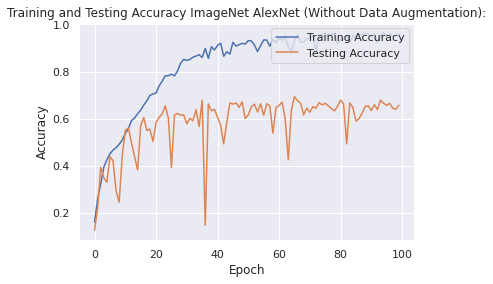

In [34]:
sns.set(font_scale=1.0)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Training and Testing Accuracy ImageNet AlexNet (Without Data Augmentation):')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Testing Accuracy'], loc='upper right')
plt.show()

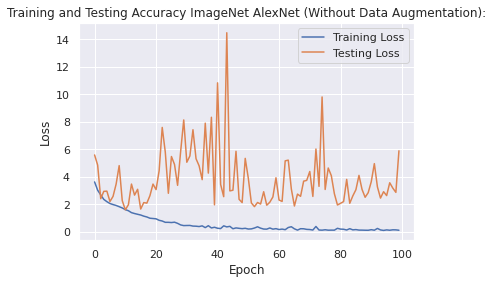

In [35]:
sns.set(font_scale=1.0)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Training and Testing Accuracy ImageNet AlexNet (Without Data Augmentation):')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Testing Loss'], loc='upper right')
plt.show()

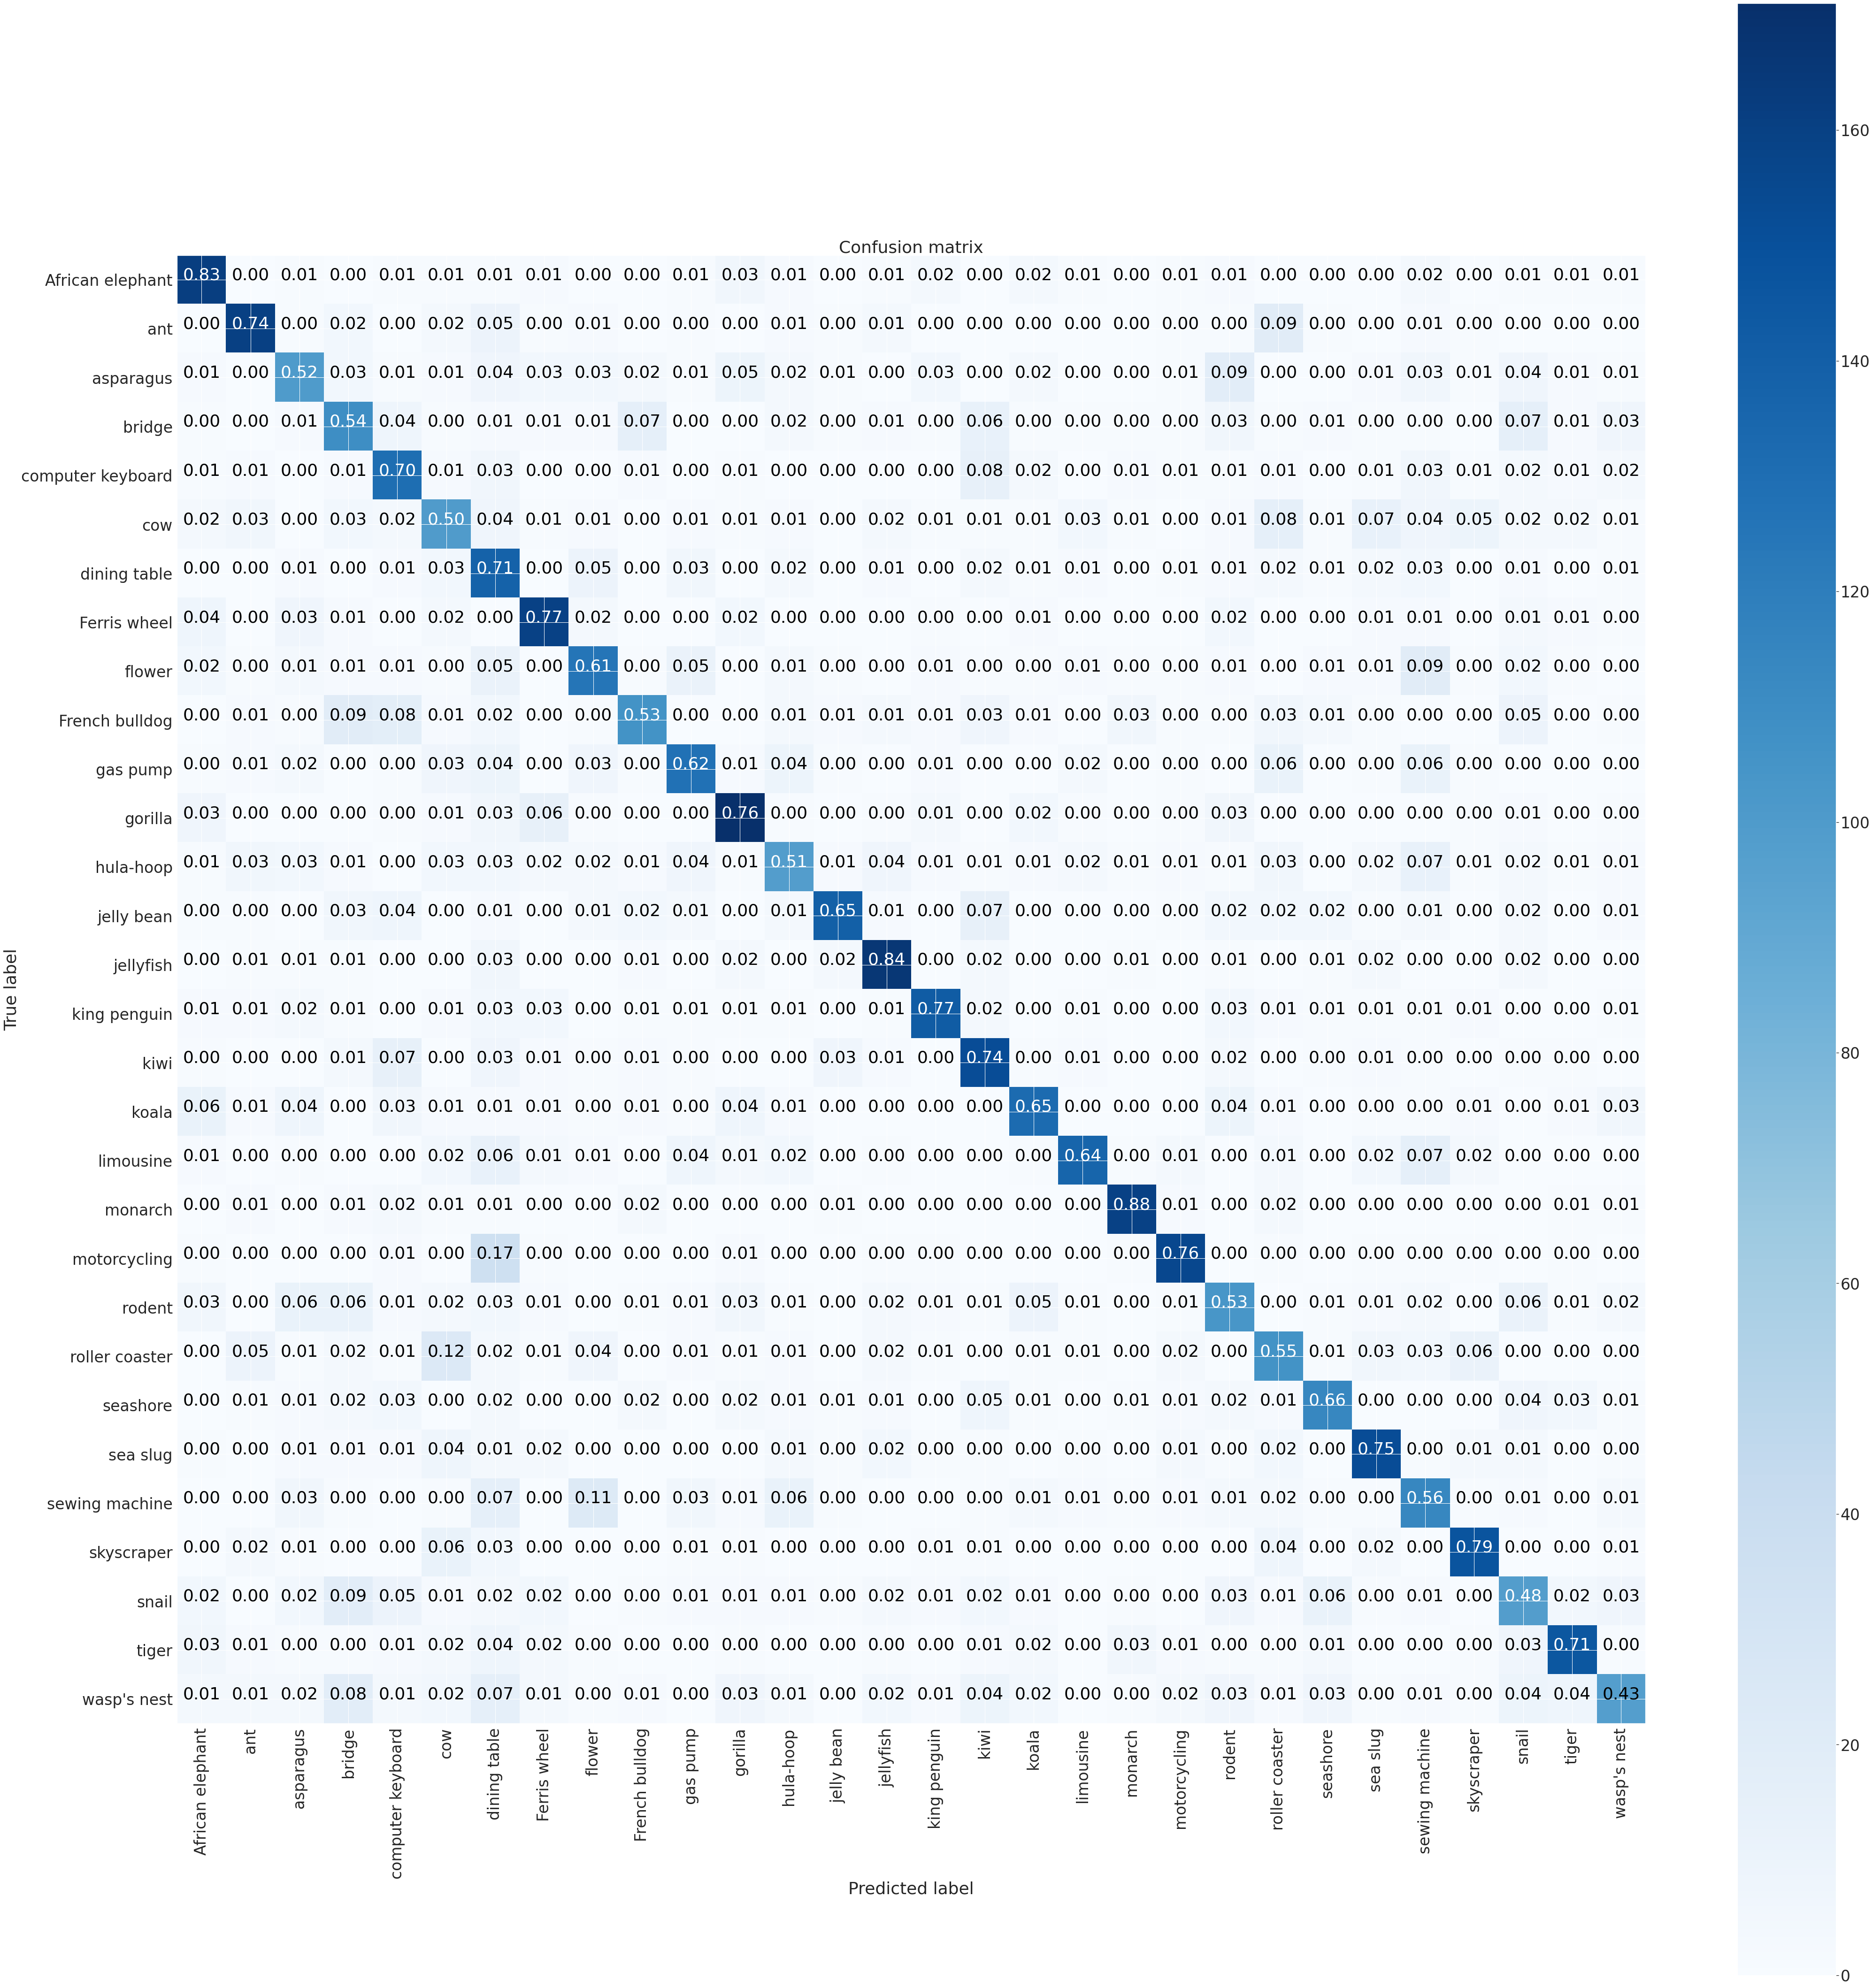

In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        thresh = cm.max() / 2.
                                                 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '%.2f'%cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
# Predict the values from the validation dataset
Y_pred = model2.predict(testing_images_norm)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
confusion_mtx = confusion_matrix(test_label, Y_pred_classes) 
# plot the confusion matrix
plt.figure(figsize=(60,60))
sns.set(font_scale=3.0)
plot_confusion_matrix(confusion_mtx, classes = ["African elephant", "ant", "asparagus", "bridge", "computer keyboard","cow","dining table","Ferris wheel","flower","French bulldog","gas pump","gorilla","hula-hoop","jelly bean","jellyfish","king penguin","kiwi","koala","limousine","monarch","motorcycling","rodent","roller coaster","seashore","sea slug","sewing machine","skyscraper","snail","tiger","wasp's nest"])